In [1]:
import time
import datetime
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sbs

import pickle

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
version = 2

### Функция для анализа результатов

In [2]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nТочность {3:.3f} на обучающей выборке\n'
        'Точность {4:.3f} на тестовой выборке\n'
        'Потеря перекрестной энтропии {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """Корреляция для реальных и предсказываемых значений"""
    data = pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,0]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )
    return data, data.corr()

def plot_confusion_matrix(
    cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues
):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказываемое значение')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [3]:
def preprocess_v2(data, use_old_scaler=False):
    num_var = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price', 'price', 'pmp']
    num_var01 = ['org_1s_sev', 'org_1s_sup_sev', 'sup_cntr_avg_penalty', 'sup_no_pnl_share', 'sup_okpd_exp', 'sup_1s_org_sev', 'sup_sim_price']
    cat_var = ['sup_type', 'sup_status', 'org_form', 'org_type', 'okpd', 'type_prod', 'cntr_lvl']
    cat_bin_var = ['price_higher_pmp', 'price_too_low']

    # Удаление строк с датой окончания контракта равной -1
    data.drop(data[data.exec_date == -1].index, inplace=True)
    # Исправление ошибки на уровне сбора данных
    data.loc[data['sup_okpd_exp'] > 1, 'sup_okpd_exp'] = 1
  
    for nv in num_var:
        data.loc[data[nv]<=1, nv] = 1
        data[nv] = np.log(data[nv])
    
    if use_old_scaler:
        # Нормализация
        scaler = load_scaler()
        data[num_var] = scaler.transform(data[num_var])
    else:
        scaler = StandardScaler()
        data[num_var] = scaler.fit_transform(data[num_var])
        save_scaler(scaler)
       
    # Удаление выбросов
    for nv in num_var:
        data['{}_rare'.format(nv)] = (np.abs(data[nv]) > 3) * 1
        data.loc[np.abs(data[nv]) > 3, nv] = 3
    
    # Исправление значений
    data.loc[data.sup_type == 0, 'sup_type'] = 3
    data.loc[(data.org_form == 45) | (data.org_form == 0), 'org_form'] = 13
    data.loc[(data.org_type == 1) | (data.org_type == -1), 'org_type'] = 12
    data.loc[data.cntr_lvl == -1, 'cntr_lvl'] = 3
  
    data['okpd_class'] = data['okpd'].apply(lambda a: pd.Series(a[:2]))
  
    cntr_start = data['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
    cntr_end = data['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
    data['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))

    # Удаление столбца
    nv01_columns_to_drop = set(num_var01) - set(['sup_okpd_exp', 'sup_sim_price'])
    columns_to_drop = list(nv01_columns_to_drop) + cat_bin_var + ['Unnamed: 0', 'sup_status', 'sign_date', 'exec_date', 'okpd']
  
    data.drop(columns_to_drop, inplace=True, axis=1)
    data.drop(data[data.cntr_length == 0].index, inplace=True)
    
    # for column in ('sup_type', 'org_form', 'org_type', 'cntr_lvl', 'type_prod', 'okpd_class'):
    #     dummies = pd.get_dummies(data[column], prefix=column[:6], drop_first=True)
    #     data = pd.concat([data, dummies], axis=1)
    #     data.drop([column], inplace=True, axis=1)
    
    return data, scaler

In [4]:
def preprocess_v1(df, sc):
    column_names = [
       'org_cntr_num', 'org_1s_sev', 'org_1s_sup_sev',
       'sup_cntr_num', 'sup_cntr_avg_price', 'sup_cntr_avg_penalty',
       'sup_no_pnl_share', 'sup_okpd_exp', 'sup_1s_sev', 'sup_1s_org_sev',
       'sup_sim_price', 'sup_type', 'org_form', 'price_higher_pmp',
       'price_too_low', 'price', 'pmp', 'okpd', 'cntr_result'
    ]
    columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price']
    df = df[column_names]
    
    X = df.drop(['cntr_result'], axis=1)
    X.loc[:, columns_to_normalize] = sc.transform(X.loc[:, columns_to_normalize])

    X.loc[X['pmp']==0, 'pmp'] = 1
    X.loc[X['price']==0, 'price'] = 1
    X['pmp'] = np.log(X['pmp'])
    X['price'] = np.log(X['price'])
    
    X = X.values
    y = df.cntr_result.values
    
    return X, y

In [5]:
def test_model(df, clf, model_name, sc, version=2):
    
    if version == 1:
        X_test, y_test = preprocess_v1(df, sc)
    else:
        X_test, y_test = preprocess_v2(df, sc)
    
    
    y_test_pred = clf.predict(X_test)
    y_test_pred_proba = clf.predict_proba(X_test)
    
    print(classification_report(y_test, y_test_pred, target_names=('Плохой', 'Хороший')))
    print('Точность {:.3f}'.format(accuracy_score(y_test, y_test_pred)))
    print('Потеря {:.3f}'.format(log_loss(y_test[:len(y_test_pred_proba)], y_test_pred_proba)))
    
    plot_confusion_matrix(
        confusion_matrix(y_test, y_test_pred), 
        classes=clf.classes_,
        title=model_name
    )
    
    res, res_corr = real_and_predicted_correlation(y_test, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_dependence(res, title=model_name)

In [6]:
def learn_one_model(classifier, clf_name, kfold=10):
    """Функция для обучения одной модели"""
    
    start_time = time.time()

    y_train_real = np.array([])
    y_test_real = np.array([])
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0, 2))
    
    kfolds_generator = KFold(n_splits=kfold, shuffle=True, random_state=random_seed)
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X)):
        print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        classifier.fit(X_train, y_train)
    
        y_train_real = np.concatenate((y_train_real, y_train))
        y_test_real = np.concatenate((y_test_real, y_test))
        y_train_pred = np.concatenate((y_train_pred, classifier.predict(X_train)))
        y_test_pred = np.concatenate((y_test_pred, classifier.predict(X_test)))
        y_test_pred_proba = np.concatenate((y_test_pred_proba, classifier.predict_proba(X_test))) 
    print("Обучение заняло %s секунд\n" % (time.time() - start_time))
    print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba)
    res, res_corr = real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_confusion_matrix(
        confusion_matrix(y_test_real, y_test_pred), 
        classes=classifier.classes_, 
        title='Матрица ошибок'
    )
    plot_dependence(res)
    plot_roc_curve(y_test_real, y_test_pred)
    return classifier

In [7]:
def save_model(clf, clf_name, version=version):
    """Сохранение модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'wb') as file:
        pickle.dump(clf, file)
        
def save_scaler(scl, version=version):
    with open('model/skaler{}.pkl'.format(version), 'wb') as file:
        pickle.dump(scl, file)

def load_model(clf_name, version=version):
    """Загрузка модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'rb') as file:
        return pickle.load(file)
    
def load_scaler(version=version):
    with open('model/skaler{}.pkl'.format(version), 'rb') as file:
        return pickle.load(file)

### Считывание данных

In [8]:
data = pd.read_csv('../data/2/tula_yarobl_finished.csv', converters={'okpd': str})
print(data.shape)
data.head(5)

(37997, 27)


,Unnamed: 0,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,...,price_higher_pmp,price_too_low,price,pmp,okpd,type_prod,cntr_lvl,sign_date,exec_date,cntr_result
0,0,480853,177,0.0,0.0,292,51386,0.0,1.0,1.0,...,0,0,15985.44,15985.44,0,19,3,20150112,20150331,0
1,1,480867,431,0.0,0.0,6,171863,0.0,1.0,1.0,...,0,0,98355.00,98850.00,0,19,3,20150110,20151231,0
2,2,481366,621,0.0,0.0,287,215299,0.0,1.0,1.0,...,0,0,82724.30,83140.00,0,19,2,20150112,20151231,0
3,3,481425,773,0.0,0.0,1,90000,0.0,1.0,1.0,...,0,0,90000.00,90000.00,0,19,2,20150112,20151231,0
4,4,481812,76,0.0,0.0,365,201042,0.0,1.0,1.0,...,0,0,107440.10,107980.00,0,19,2,20150114,20150430,0


### Предобработка
#### Обработка количественных переменных
1. Логарифмирование всех переменных, так как они имеют большие правые хвосты
2. Нормирование
3. Удаление выбросов (сохраняем все, что внутри интервала [-3sig, 3sig]

#### Обработка количественных переменных в диапозоне [0, 1]
1. Удалить все переменные кроме sup_okpd_exp и sup_sim_price
2. Нормировать

#### Обработка категориальных переменных
1. Удалить переменную sup_status
2. sup_type -> 0 = 3
3. org_form -> 45 = 13; 0 = 13
4. org_type -> 1 = 12; -1 = 12
5. type_prod -> -1 = 19
6. cntr_lvl -> -1 = 3

#### Обработка категориальных бинарных переменных
1. Удалить обе переменные

### Feature Engineering
1. Производная переменная, учитывающая только класс от ОКПД 
2. Переменную, определяющая длину контракта с последующим удалением sign_date, exec_date)
3. PMP и Price имеют высокую корреляцию, а также price и sup_cntr_avg_price. Необходимо какие-то из переменных исключить.

In [9]:
data, _ = preprocess_v2(data.copy())

In [10]:
print(data.shape)
data.head()

(37830, 22)


,cntrID,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,sup_okpd_exp,sup_1s_sev,sup_sim_price,sup_type,org_form,org_type,...,type_prod,cntr_lvl,cntr_result,org_cntr_num_rare,sup_cntr_num_rare,sup_cntr_avg_price_rare,price_rare,pmp_rare,okpd_class,cntr_length
0,480853,-0.303711,0.225361,-1.069622,1.0,0,0.10616,3,13,11,...,19,3,0,0,0,0,0,0,0,78
1,480867,0.380921,-1.051567,0.023394,1.0,0,0.16667,3,13,41,...,19,3,0,0,0,0,0,0,0,355
2,481366,0.661882,0.219684,0.227389,1.0,0,0.07666,3,13,12,...,19,2,0,0,0,0,0,0,0,353
3,481425,0.830315,-1.640486,-0.562244,1.0,0,1.00000,1,8,41,...,19,2,0,0,0,0,0,0,0,353
4,481812,-0.954077,0.298704,0.165362,1.0,0,0.10411,3,13,11,...,19,2,0,0,0,0,0,0,0,106


In [11]:
X = data.drop(['cntrID', 'cntr_result'], axis=1).values
y = data.cntr_result.values

In [12]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
save_model(xgb, 'xgb')

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

print('Acc: {}, Log_loss: {}'.format(accuracy_score(y_test, y_pred), log_loss(y_test, y_pred_proba)))

Acc: 0.9226804123711341, Log_loss: 0.20153827190883017
CPU times: user 1.6 s, sys: 17.5 ms, total: 1.62 s
Wall time: 1.65 s


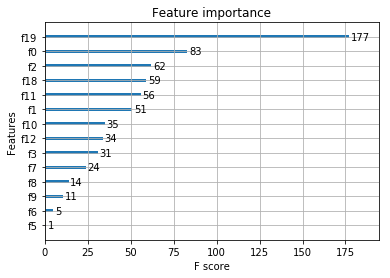

In [13]:
plot_importance(xgb)

Обучение 1 разбиения
Обучение 2 разбиения
Обучение 3 разбиения
Обучение 4 разбиения
Обучение 5 разбиения
Обучение 6 разбиения
Обучение 7 разбиения
Обучение 8 разбиения
Обучение 9 разбиения
Обучение 10 разбиения
Обучение заняло 18.914202213287354 секунд

XGB

             precision    recall  f1-score   support

     Плохой       0.99      0.85      0.92     18794
    Хороший       0.87      0.99      0.93     19036

avg / total       0.93      0.92      0.92     37830

Точность 0.923 на обучающей выборке
Точность 0.922 на тестовой выборке
Потеря перекрестной энтропии 0.197


              result  proba_pred      pred
result      1.000000   -0.873949  0.851442
proba_pred -0.873949    1.000000 -0.975746
pred        0.851442   -0.975746  1.000000


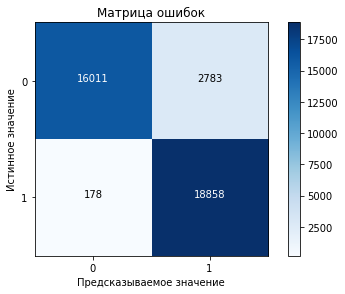

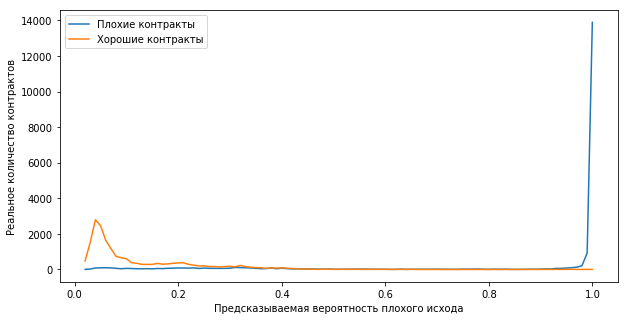

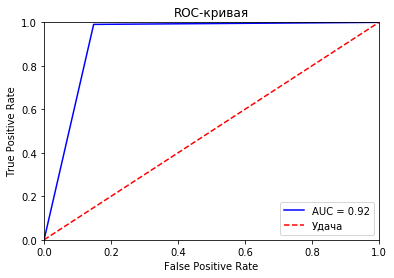

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
learn_one_model(XGBClassifier(), 'XGB')